In [1]:
import numpy as np
import torch
import warnings
import shutil
import open_clip
from open_clip import tokenizer
import time

import os, glob
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

from collections import OrderedDict
import torch

import importlib

# import CLIP_GA
# importlib.reload(CLIP_GA)
#from CLIP_GA import *


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Ignore all warnings5
warnings.filterwarnings("ignore")

# Load Module

In [2]:
import CLIP_Module
importlib.reload(CLIP_Module)
from CLIP_Module import *  # Re-import function to reflect updates

# Load Images

In [3]:
Florida_Images_Folders = (
    glob.glob('../../examples/*.jpg') +
    glob.glob('../../examples/*.png')
)


In [4]:
images_paths_map = {x.split('/')[-1].split('_')[0]: x for x in Florida_Images_Folders}
photo_ids = [x.split('/')[-1].split('_')[0] for x in Florida_Images_Folders]

# Inference

## Load BRF

In [5]:
clf = joblib.load("../../model/BRF_model.joblib")

## Load CLIP

In [6]:
# Load CLIP Model
model_name = 'MobileCLIP-S1'  # Replace with your model
pretrained = 'datacompdr'      # Specify the pretrained source
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)  # Correct tokenizer initialization

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval(); #Important to turn on.


## BRF first level inference

In [7]:
import psutil

y_pred = []
images = []
images_valid = [] #1 valid; 0: corruption
start_time = time.perf_counter()
n = 1

sub_start_time = time.perf_counter()
for idx in range(len(photo_ids)):
    try:
        image_path = images_paths_map[str(photo_ids[idx])]
        image = Image.open(image_path).convert("RGB")
        images_valid.append(1)
    except:
        image_path = images_paths_map[str(photo_ids[0])] #Fake Image
        image = Image.open(image_path).convert("RGB")
        images_valid.append(0)
    
    images.append(preprocess(image).to(device))
    
    if (idx+1)%500 == 0 or (idx+1) == len(photo_ids):
        image_input = torch.stack(images).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            
        image_features_cpu = np.array(image_features.cpu())

        pred = clf.predict(image_features_cpu) #RF prediciton
        y_pred.append(pred)

        del image_input, image_features, images, image_features_cpu
        torch.cuda.empty_cache()  # Clear unused memory
        images = []
        
        # Get the memory usage in bytes
        memory_usage = psutil.Process().memory_info().rss

        # Convert to megabytes
        memory_usage_mb = memory_usage / (1024 ** 2)
        
        # End the timer
        sub_end_time = time.perf_counter()
        # Calculate the time taken
        sub_execution_time = sub_end_time - sub_start_time
        sub_start_time = time.perf_counter()
        print(f"{n} Execution time: {sub_execution_time:.6f} seconds")
        print(f"Memory Usage: {memory_usage_mb:.2f} MB")
        n+=1

y_pred_flat = np.concatenate(y_pred) #1: CES; 0:Other

1 Execution time: 22.861548 seconds
Memory Usage: 1448.13 MB


## CLIP second level inference

In [8]:
descriptions = {
    "Hiking": "This is an image of people hiking or taking a casual walk on challenging scenic trails or through breathtaking countryside.",
    "Boating": "This is an image of boating with powerboats or human-powered vessels such as rowboats or paddle boats.",
    "Swimming":"This is an image of people wearing swimsuits while swimming in a pool, lake, or ocean.",
    "Camping":"This is camping.",
    "Fishing":"This is fishing.",
    "Biking":"This is biking.",
    "Horseback_Riding":"This is horseback riding.",
    "Wildlife_Viewing":"This is an image without people, showing wildlife such as birds, flowers, or fungi in a natural environment.", 
    "Shelling":"This is shelling.",
    "Surfing": "This is an image of people surfing on ocean waves or holding a surfboard on the beach.",
    "Hunting": "This is an image of a hunter posing with a large kill, cleaning or gutting the carcass of a feral animal.",
    "Landscape_Aesthetics":"This is an image without people, showing a natural, soothing, and vibrant panoramic landscape."
}

class_names = ["Hiking", "Boating", "Swimming", "Camping", "Fishing", "Biking", "Horseback_Riding", "Wildlife_Viewing",
              "Shelling", "Surfing", "Hunting","Landscape_Aesthetics"]

texts = []
for name in descriptions:
    texts.append(descriptions[name])

     
text_tokens = tokenizer([desc for desc in texts]).to(device)


images = []
images_valid = [] #1: valid; 0: corruption
original_images = []
predicted_cover_labels_col = []

# Start the timer
start_time = time.perf_counter()
n = 1
for idx in range(len(photo_ids)):
    sub_start_time = time.perf_counter()

    try:
        image_path = images_paths_map[str(photo_ids[idx])]
        image = Image.open(image_path).convert("RGB")
        images_valid.append(1)
    except:
        image_path = images_paths_map[str(photo_ids[0])] #Fake Image
        image = Image.open(image_path).convert("RGB")
        images_valid.append(0)
        continue
    
    images.append(preprocess(image).to(device))
    
    if (idx+1)%500 == 0 or (idx+1) == len(photo_ids):
        image_input = torch.stack(images).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            text_features = model.encode_text(text_tokens).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        subsimilarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
        predicted_cover_labels, top = GetPred(subsimilarity, class_names)
        predicted_cover_labels_col += predicted_cover_labels
        
        if n == 1:
            tops = top.copy()
        else:
            tops = np.vstack((tops, top.copy()))
        
        n+=1
    
        del image_input, image_features, text_features, subsimilarity, images, predicted_cover_labels, top
        torch.cuda.empty_cache()  # Clear unused memory
        images = []
        
        # End the timer
        sub_end_time = time.perf_counter()
        # Calculate the time taken
        sub_execution_time = sub_end_time - sub_start_time
        print(f"{n} Execution time: {sub_execution_time:.6f} seconds")
    
# End the timer
end_time = time.perf_counter()
# Calculate the time taken
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

2 Execution time: 2.830412 seconds
Execution time: 3.088540 seconds


# Outcomes

In [9]:
res = {
    "pid": [],
    "CLIP-BRF-ZS": [],
    "Image_Path": []
}

for i, pid in enumerate(photo_ids):
    res["pid"].append(pid)

    label = (
        predicted_cover_labels_col[i]
        if y_pred_flat[i] == 1
        else "Other"
    )
    res["CLIP-BRF-ZS"].append(label)

    res["Image_Path"].append(images_paths_map.get(pid, None))


df_res = pd.DataFrame(res)

In [10]:
#df_res.to_csv("df_res.csv", index=False) #SaveRes

# Example Outputs

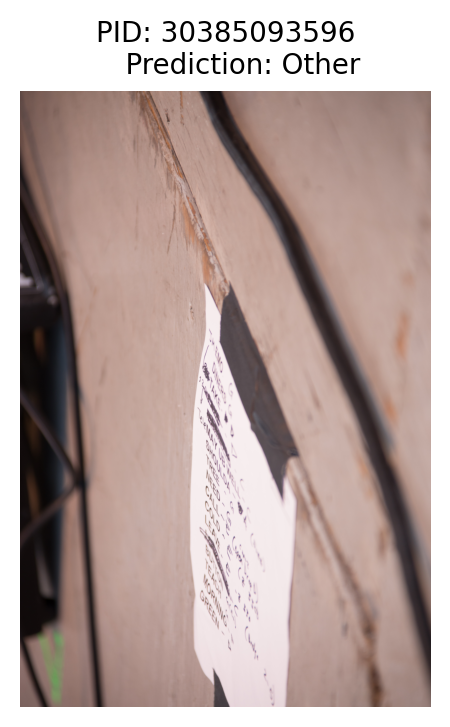

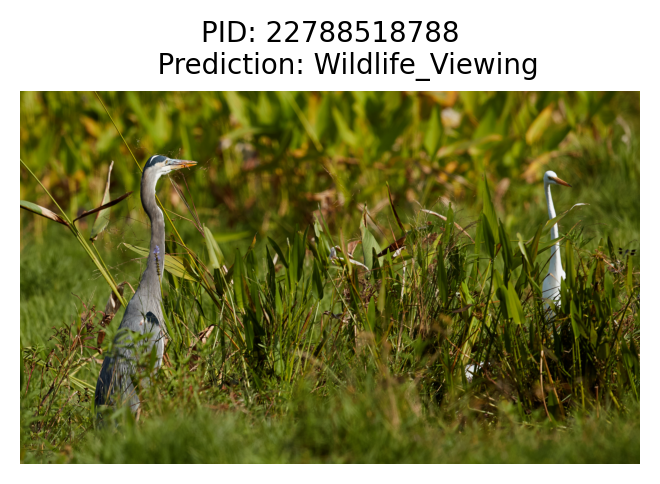

In [11]:
for i in range(2):
    img = Image.open(df_res.loc[i, "Image_Path"])

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    title = f"""
    PID: {df_res.loc[i, 'pid']}
    Prediction: {df_res.loc[i, 'CLIP-BRF-ZS']}
    """
    plt.title(title.strip(), fontsize=10)
    plt.show()
